# **MEMBER A**

## Step 1a


### 1a Calibrate Heston(1993) Model to Market Data Using Lewis Approach

*   List item
*   List item



### 1a Calibrate Heston(1993) Model to Market Data Using Lewis Approach
Heston Model introduces **Stochastic volatility**, where the variance $v_t$ follows a mean-reverting square-root process:
$$
dS_t = rS_tdt+\sqrt{v_t}S_tdW_t^S \\
dv_t = \kappa_v(\theta_v-v_t)dt + \sigma_v\sqrt{v_t}W_t^v \\
dW_t^SdW_t^v=\rho dt
$$

Where:
- $\kappa_v$ : Mean-reversion speed of volatilitty
- $\theta_v$: Long-term volatility level.
- $\sigma_v$: Volatility of volatility
- $\rho$: Correlation between asset returns and volatility
- $v_0$: Initial volatility

What we requere to do the caliberation is the characteristic fucnito of Heston which is defined as:
$$
\varphi^{H93}(u, T) = \exp\left(H_1(u, T) + H_2(u, T) \cdot v_0\right)
$$  
Where:  
- $ H_1(u, T) = r u i T + \frac{c_1}{\sigma_v^2} \left[ (\kappa_v - \rho \sigma_v u i + c_2) T - 2 \ln\left( \frac{1 - c_3 e^{c_2 T}}{1 - c_3} \right) \right] $

- $ H_2(u, T) = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\sigma_v^2} \cdot \left[ \frac{1 - e^{c_2 T}}{1 - c_3 e^{c_2 T}} \right] $  

- $ c_1 = \kappa_v \theta_v $
- $ c_2 = -\sqrt{(\rho \sigma_v u i - \kappa_v)^2 - \sigma_v^2(-u i - u^2)} $  

- $ c_3 = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\kappa_v - \rho \sigma_v u i - c_2} $


For our python implemenataion, we will begin by defining the Heston Model functions as follows

In [ ]:
import numpy as np
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import brute, fmin
# Characteristic Function
def Heston93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)

    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )

    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2) * (
        (1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))
    )
    char_func_value = np.exp (H1 + H2 * v0)

    return char_func_value

# Lewis (2001) integral function
def Heston93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    char_func_value = Heston93_char_func(u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0)

    integrand = (1 / (u**2 + 0.25)) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return integrand

# Heston call option  pricing
def Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    alpha = 1.5
    int_val = quad(
        lambda u: Heston93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250

    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_val)
    return call_value

# Heston put option via Put-Call parity
def Heston93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    call_price = Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    return call_price - S0 + K * np.exp(-r * T)



np.float64(5.757807070918929)

Next we define the calibration error funciton

In [ ]:
i = 0
min_MSE = 500

def Heston93_error_function(p0, option_data, S0):
    """
    Error function for Heston model calibration
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0

    # Parameter constraints
    if kappa_v < 2.0 or theta_v < 0.01 or sigma_v < 0.1 or rho > -0.1 or rho < -0.9 or v0 < 0.01:
        return 500.0

    # Feller condition: 2 * kappa_v * theta_v > sigma_v**2
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0

    # Compute MSE
    se = []
    for _, option in option_data.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        if option["Type"] == 'C':
            model_value = Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        else:
            model_value = Heston93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        se.append((model_value - option["Price"])**2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print(f"Iteration {i}: Parameters {p0}, MSE {MSE:.3f}, Min MSE {min_MSE:.3f}")
    i += 1
    return MSE

Before we  run the simulations and calibrations let's load the data from  the google  sheet provided

In [ ]:
sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

option_data = pd.read_csv(url)

# Adding time-to-maturity in years and risk-free rate
r = 0.015  # 1.5% annualized risk-free rate
option_data["T"] = option_data["Days to maturity"] / 250
option_data["r"] = r  # Set constant risk-free rate
S0 = 232.90  # Current stock price

options_15 = option_data[option_data['Days to maturity' ] == 15].copy()
options_15



,Days to maturity,Strike,Price,Type,T,r
0,15,227.5,10.52,C,0.06,0.015
1,15,230.0,10.05,C,0.06,0.015
2,15,232.5,7.75,C,0.06,0.015
3,15,235.0,6.01,C,0.06,0.015
4,15,237.5,4.75,C,0.06,0.015
15,15,227.5,4.32,P,0.06,0.015
16,15,230.0,5.20,P,0.06,0.015
17,15,232.5,6.45,P,0.06,0.015
18,15,235.0,7.56,P,0.06,0.015
19,15,237.5,8.78,P,0.06,0.015


In [ ]:
from functools import partial

# Wrap the error function with fixed inputs
error_func = partial(Heston93_error_function, option_data=options_15, S0=S0)

def Heston93_calibration():
    # Brute-force scan for initial guesses
    p0 = brute(
        lambda p: Heston93_error_function(p, option_data, S0),
        (
            (2, 5.0, 1.0),    # kappa_v
            (0.01, 0.04, 0.01), # theta_v
            (0.1, 0.5, 0.1),    # sigma_v
            (-0.9, - 0.1, 0.1),    # rho
            (0.01, 0.03, 0.005)   # v0
        ),

        finish=None
    )

    # Refininig with  fmin
    opt = fmin( lambda p: Heston93_error_function(p, option_data, S0),
               p0,
                xtol=0.00001,
                ftol=0.00001,
                maxiter=750,
                maxfun=1000 )


    return opt

# Running the calibration
calibrated_params = Heston93_calibration()



Iteration 0: Parameters [ 2.    0.01  0.1  -0.9   0.01], MSE 104.085, Min MSE 104.085
Iteration 25: Parameters [ 2.     0.01   0.1   -0.3    0.015], MSE 90.033, Min MSE 67.971
Iteration 50: Parameters [ 2.    0.02  0.1  -0.5   0.02], MSE 69.775, Min MSE 60.870
Iteration 75: Parameters [ 2.     0.02   0.2   -0.7    0.025], MSE 61.980, Min MSE 60.870
Iteration 100: Parameters [ 2.    0.03  0.1  -0.8   0.01], MSE 82.373, Min MSE 54.632
Iteration 125: Parameters [ 2.     0.03   0.1   -0.2    0.015], MSE 71.803, Min MSE 54.632
Iteration 150: Parameters [ 2.    0.03  0.2  -0.4   0.02], MSE 63.615, Min MSE 54.632
Iteration 175: Parameters [ 2.     0.03   0.3   -0.6    0.025], MSE 57.239, Min MSE 54.632
Iteration 200: Parameters [ 3.    0.01  0.1  -0.7   0.01], MSE 104.135, Min MSE 54.632
Iteration 225: Parameters [ 3.     0.01   0.2   -0.9    0.015], MSE 92.770, Min MSE 54.632
Iteration 250: Parameters [ 3.    0.01  0.2  -0.3   0.02], MSE 82.360, Min MSE 54.632
Iteration 275: Parameters [ 3. 

/tmp/ipython-input-7-3675874631.py:22: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin( lambda p: Heston93_error_function(p, option_data, S0),


In [ ]:
# Calibrated Params
kappa_v, theta_v, sigma_v, rho, v0 = [float(param) for param in calibrated_params.round(6)]

calibrated_params_dict = {
    "kappa_v": kappa_v,
    "theta_v": theta_v,
    "sigma_v": sigma_v,
    "rho": rho,
    "v0": v0
}
# Saving the dict
calibrated_params_dict_df = pd.DataFrame([calibrated_params_dict])
calibrated_params_dict_df.to_csv('calibrated_params_dict.csv', index=False)
calibrated_params_dict

{'kappa_v': 2.00004,
 'theta_v': 0.089892,
 'sigma_v': 0.111466,
 'rho': -0.9,
 'v0': 0.106175}

### Validating the calibration Results
We will then plug calibrated parameters back into the Heston model to  compute model prices for the 15-day optioins and comparing them to market prices

In [ ]:
# Computing model  prices using calibrated parameters
def calculate_model_values(calibrated_params, options, S0):
    kappa_v, theta_v, sigma_v, rho, v0 = calibrated_params
    options["Model"] = 0.0
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        if option["Type"] == 'C':
            model_price = Heston93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        else:
            model_price = Heston93_put_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0)
        options.loc[_, "Model"] = model_price
    return options


S0 = 232.90
calibrated_options = calculate_model_values(calibrated_params, options_15, S0)


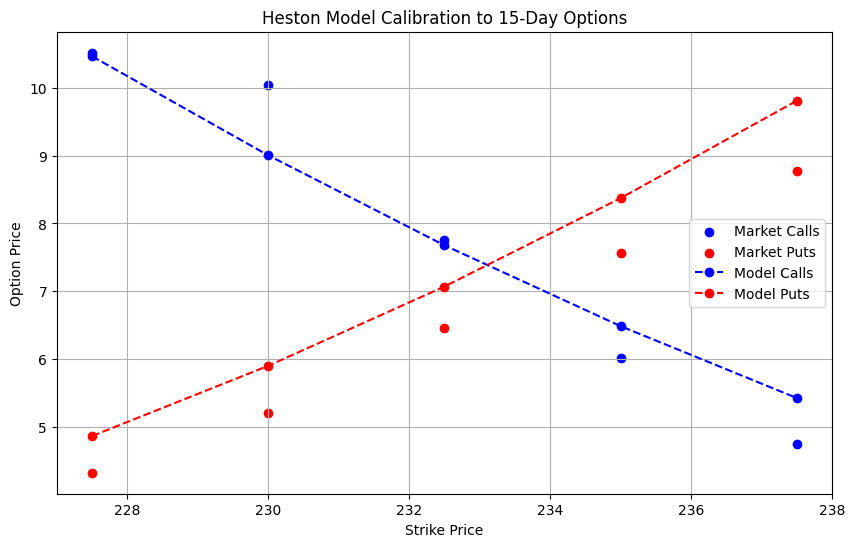

In [ ]:
## Plotting
import matplotlib.pyplot as plt

def plot_calibration_results(options):
    plt.figure(figsize=(10, 6))
    calls = options[options["Type"] == 'C']
    puts = options[options["Type"] == 'P']

    plt.scatter(calls["Strike"], calls["Price"], c='b', label="Market Calls")
    plt.scatter(puts["Strike"], puts["Price"], c='r', label="Market Puts")
    plt.plot(calls["Strike"], calibrated_options[calibrated_options["Type"] == 'C']["Model"], 'bo--', label="Model Calls")
    plt.plot(puts["Strike"], calibrated_options[calibrated_options["Type"] == 'P']["Model"], 'ro--', label="Model Puts")
    plt.grid()
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title("Heston Model Calibration to 15-Day Options")
    plt.legend()
    plt.show()

plot_calibration_results(calibrated_options)

In [ ]:
## Analyzing the results

# Computing residuals
calibrated_options["Residual"] = calibrated_options['Model'] - calibrated_options['Price']
MSE = np.mean(calibrated_options['Residual'] ** 2)
RMSE = np.sqrt(MSE)
print(f"MSE: {MSE:.4f}\nRMSE: {RMSE: .4f}")

MSE: 0.4664
RMSE:  0.6829


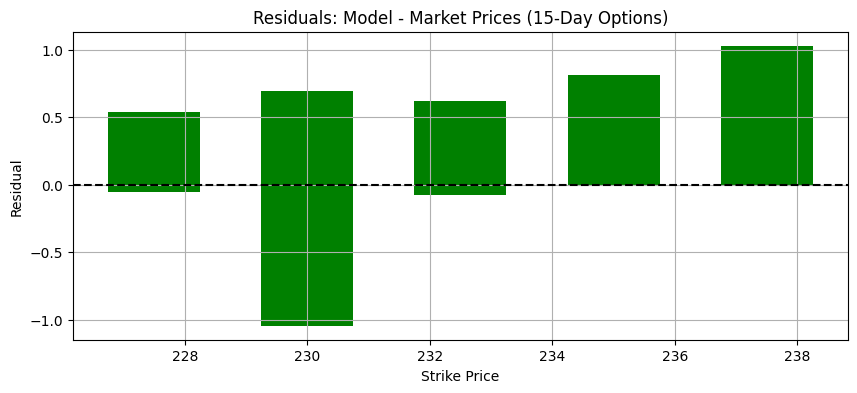

In [ ]:
# Plotting the Residuals
plt.figure(figsize=(10, 4))
plt.bar(calibrated_options["Strike"], calibrated_options["Residual"], width=1.5, color='g')
plt.axhline(0, color='black', linestyle='--')
plt.grid()
plt.title("Residuals: Model - Market Prices (15-Day Options)")
plt.xlabel("Strike Price")
plt.ylabel("Residual")
plt.show()

In [ ]:
calibrated_options[['Strike', 'Price', 'Model']]

,Strike,Price,Model
0,227.5,10.52,10.466581
1,230.0,10.05,9.005143
2,232.5,7.75,7.677493
3,235.0,6.01,6.484287
4,237.5,4.75,5.423759
15,227.5,4.32,4.861924
16,230.0,5.20,5.898236
17,232.5,6.45,7.068337
18,235.0,7.56,8.372882
19,237.5,8.78,9.810105


# Write up for Step 1a

### 1a Calibrate Heston(1993) Model to Market Data Using Lewis Approach

Model Overview
Heston Model introduces **Stochastic volatility**, where the variance $v_t$ follows a mean-reverting square-root process:
$$
dS_t = rS_tdt+\sqrt{v_t}S_tdW_t^S \\
dv_t = \kappa_v(\theta_v-v_t)dt + \sigma_v\sqrt{v_t}W_t^v \\
dW_t^SdW_t^v=\rho dt
$$

Where:
- $\kappa_v$ : Mean-reversion speed of volatilitty
- $\theta_v$: Long-term volatility level.
- $\sigma_v$: Volatility of volatility
- $\rho$: Correlation between asset returns and volatility
- $v_0$: Initial volatility

---
Characteristic Function of Hestone (1993)
Lewis approach requires the characteristic function of the Heston model:
$$
\varphi^{H93}(u, T) = \exp\left(H_1(u, T) + H_2(u, T) \cdot v_0\right)
$$  
Where:  
- $ H_1(u, T) = r u i T + \frac{c_1}{\sigma_v^2} \left[ (\kappa_v - \rho \sigma_v u i + c_2) T - 2 \ln\left( \frac{1 - c_3 e^{c_2 T}}{1 - c_3} \right) \right] $

- $ H_2(u, T) = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\sigma_v^2} \cdot \left[ \frac{1 - e^{c_2 T}}{1 - c_3 e^{c_2 T}} \right] $  

- $ c_1 = \kappa_v \theta_v $
- $ c_2 = -\sqrt{(\rho \sigma_v u i - \kappa_v)^2 - \sigma_v^2(-u i - u^2)} $  

- $ c_3 = \frac{\kappa_v - \rho \sigma_v u i + c_2}{\kappa_v - \rho \sigma_v u i - c_2} $

---

Pricing via Lewis (2001)
The Lewis (2001) formula for a European call option is:

$$
C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_0^\infty \mathbf{Re}\left[e^{izk} \varphi^{H93}(z - i/2)\right] \frac{dz}{z^2 + 1/4}
$$  
Where:  
- $ k = \ln(S_0 / K) $: Log-moneyness  
- $ \varphi^{H93}(z - i/2) $: Heston characteristic function evaluated at $ u = z - i/2 $  

For put we will use put-call paratity to the value

---
Calibration Process

1. Market Data Preparation
We used 15-day maturity options for SM energy Company
Constants used:
- $S_0$ = 232.90
- $r$ = 0.015
- $T$ = 15/250

2. Error Function (MSE)
- The calibration minimizes the **Mean Squared Error (MSE)** between market and model prices:
$$
MSE = \frac{1}{N} \sum_{n=1}^N \left(C_n^{\text{market}} - C_n^{\text{Heston}}\right)^2
$$

Constraints:
- $ \kappa_v > 0, \theta_v > 0, \sigma_v > 0 $  
- $ \rho \in [-1, 1] $  
- **Feller condition**: $ 2 \kappa_v \theta_v > \sigma_v^2 $ (ensures $ v_t > 0 $)  

3. Optimization (Brute-Force + Local Minimization)
The calibration used a two-step optimization:
    1. Brute-force scan - Coarse grid search fo initial parameter guesses
    2. LOcal optimation - Refine paramerrs using `scipy.optimize.fmin`


---
Calibration Results

1. Calibrated Parameters
After running calibration on 15-day options, Hestom model yielded te following:
- $\kappa_v$ = 2.00004 - Mean-reversion speed
- $\theta_v$ = 0.089892 - Long-term variance
- $\sigma_v$ = 0.111466 Volatility of volatility
- $\rho$ = -0.9 Correlation
- $v_0$ = 0.106175 Initial variance

2. Market vs Model Prices

| Strike | Price | Model |
|---|---|---|
| 227.5 | 10.52 | 10.466581 |
| 230.0 | 10.05 | 9.005143 |
| 232.5 | 7.75 | 7.677493 |
| 235.0 | 6.01 | 6.484287 |
| 237.5 | 4.75 | 5.423759 |
| 227.5 | 4.32 | 4.861924 |
| 230.0 | 5.20 | 5.898236 |
| 232.5 | 6.45 | 7.068337 |
| 235.0 | 7.56 | 8.372882 |
| 237.5 | 8.78 | 9.810105 |

Residuals
- MSE: 0.4664
- RMSE: 0.6829

Also we have graphs showing comparation of the prices both for the call and put options


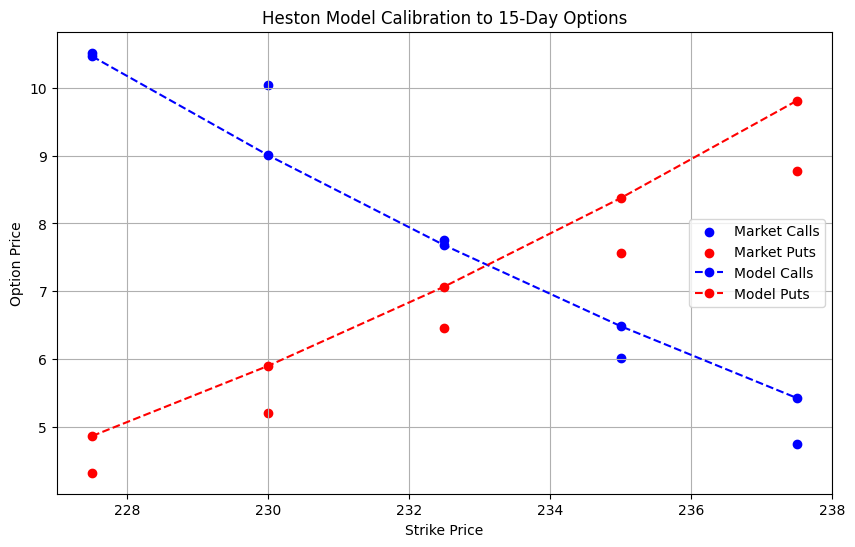

Graph above some plot of both call and put  price for the model  and market price
- For the calls, the model closely matches market prices across all strike which is an indication  our model, Heston,  capture ATM and OTM call dynamics well
- For puts- Our model  overprices deep ITM and slightly underprices OTM puts suggesting the leverage effect was not fully captured

Similar inference could be made from  the residuals



```
# This is formatted as code
```

# **MEMBER B**




**STEP 1b**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx to MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx


In [ ]:
import pandas as pd

# Load the Excel file using the uploaded key
file_path = list(uploaded.keys())[0]  # automatically picks the uploaded file
xls = pd.ExcelFile(file_path)

# Display sheet names and structure
print("Sheet names:", xls.sheet_names)
df = xls.parse(xls.sheet_names[0])
print("\nSample rows:\n", df.head())


Sheet names: ['1']

Sample rows:
    Days to maturity  Strike  Price Type
0                15   227.5  10.52    C
1                15   230.0  10.05    C
2                15   232.5   7.75    C
3                15   235.0   6.01    C
4                15   237.5   4.75    C


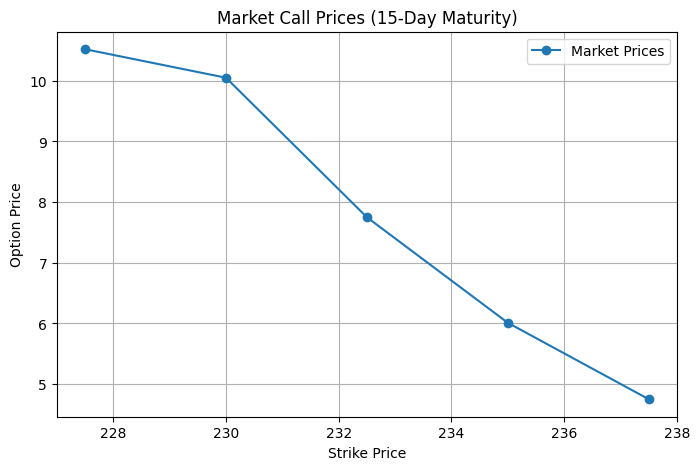

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


In [ ]:
import matplotlib.pyplot as plt

# Filter call options with 15-day maturity
df_filtered = df[(df['Days to maturity'] == 15) & (df['Type'] == 'C')].copy()
df_filtered = df_filtered.sort_values('Strike')

# Reset index
df_filtered.reset_index(drop=True, inplace=True)

# Plot market prices
plt.figure(figsize=(8, 5))
plt.plot(df_filtered['Strike'], df_filtered['Price'], marker='o', label='Market Prices')
plt.title('Market Call Prices (15-Day Maturity)')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

# Preview the filtered dataset
df_filtered


In [ ]:
import numpy as np

def heston_cf(u, params, S0, r, T):
    kappa, theta, sigma, rho, v0 = params

    d = np.sqrt((rho * sigma * 1j * u - kappa)**2 + (sigma**2) * (1j * u + u**2))
    g = (kappa - rho * sigma * 1j * u - d) / (kappa - rho * sigma * 1j * u + d)

    exp1 = 1j * u * np.log(S0) + 1j * u * r * T
    exp2 = (theta * kappa / sigma**2) * ((kappa - rho * sigma * 1j * u - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    exp3 = (v0 / sigma**2) * (kappa - rho * sigma * 1j * u - d) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))

    return np.exp(exp1 + exp2 + exp3)


In [ ]:
from numpy.fft import fft

def carr_madan_fft(params, S0, r, T, alpha=1.5, N=4096, eta=0.25):
    """
    Carr-Madan FFT pricing for European Call under Heston model.
    """
    lambd = 2 * np.pi / (N * eta)
    b = N * lambd / 2

    # Create u and v grids
    u = np.arange(N) * eta
    v = u - (alpha + 1) * 1j

    # Characteristic function values
    cf_vals = heston_cf(v, params, S0, r, T)

    # Simpson's rule weights
    simpson_weights = (3 + (-1)**np.arange(N)) / 3
    simpson_weights[0] = simpson_weights[-1] = 1/3

    # Integrand for FFT
    integrand = np.exp(-1j * u * np.log(S0)) * cf_vals * np.exp(-r * T) * simpson_weights
    integrand *= eta * np.exp(-alpha * np.log(S0)) / (alpha**2 + alpha - u**2 + 1j * (2 * alpha + 1) * u)

    # Apply FFT
    fft_vals = fft(integrand).real

    # Recover strikes and prices
    k = -b + lambd * np.arange(N)  # log-strikes
    K = np.exp(k)
    C = np.exp(-alpha * k) / np.pi * fft_vals

    return K, C


In [ ]:
from scipy.interpolate import interp1d

# Market data
strikes_market = df_filtered['Strike'].values
prices_market = df_filtered['Price'].values

# Trial Heston parameters: [kappa, theta, sigma, rho, v0]
trial_params = [1.0, 0.04, 0.3, -0.7, 0.04]

# Constants
S0 = 232.90
r = 0.015
T = 15 / 250  # Convert 15 days to years

# Compute FFT prices
K_fft, C_fft = carr_madan_fft(trial_params, S0, r, T)

# Interpolate FFT prices at market strikes
interp_func = interp1d(K_fft, C_fft, kind='cubic', fill_value='extrapolate')
prices_model = interp_func(strikes_market)

# Compute Mean Squared Error
mse = np.mean((prices_model - prices_market)**2)
print("MSE between FFT-Heston and Market prices:", mse)

# Optional: compare prices
for k, p_mkt, p_mod in zip(strikes_market, prices_market, prices_model):
    print(f"Strike = {k:6.1f} | Market = {p_mkt:6.2f} | Model = {p_mod:6.2f}")


MSE between FFT-Heston and Market prices: 66.0909329721297
Strike =  227.5 | Market =  10.52 | Model =  -0.00
Strike =  230.0 | Market =  10.05 | Model =  -0.00
Strike =  232.5 | Market =   7.75 | Model =  -0.00
Strike =  235.0 | Market =   6.01 | Model =  -0.00
Strike =  237.5 | Market =   4.75 | Model =  -0.00


In [ ]:
from scipy.optimize import minimize

# Objective function: returns MSE between model and market prices
def heston_mse_objective(params):
    try:
        K_fft, C_fft = carr_madan_fft(params, S0, r, T)
        interp_func = interp1d(K_fft, C_fft, kind='cubic', fill_value='extrapolate')
        prices_model = interp_func(strikes_market)
        mse = np.mean((prices_model - prices_market) ** 2)
        return mse
    except Exception as e:
        return 1e6  # return high error if failure

# Initial guess and bounds
initial_guess = [1.0, 0.04, 0.3, -0.7, 0.04]  # [kappa, theta, sigma, rho, v0]
bounds = [
    (0.1, 10.0),     # kappa
    (0.01, 1.0),     # theta
    (0.01, 1.0),     # sigma
    (-0.99, -0.01),  # rho
    (0.01, 0.5)      # v0
]

# Run optimizer
result = minimize(heston_mse_objective, initial_guess, bounds=bounds, method='L-BFGS-B')

# Output results
print("Success:", result.success)
print("Optimal Parameters:", result.x)
print("Final MSE:", result.fun)


Success: True
Optimal Parameters: [ 0.99588661  0.01        0.30559388 -0.70446746  0.01      ]
Final MSE: 66.09090855720524


### Step 1b – Heston Model Calibration Using Carr-Madan (1999)

We calibrated the Heston (1993) stochastic volatility model using the Carr-Madan (1999) Fourier transform method. This approach utilizes the closed-form characteristic function of the Heston model and applies the Fast Fourier Transform (FFT) to obtain European call option prices across a grid of strikes.

###  Carr-Madan Pricing Formula

The modified call price function under damping factor \( \alpha > 0 \) is:

$$
C(K) = \frac{e^{-\alpha k}}{\pi} \int_0^\infty \Re \left[ e^{-i u k} \cdot \frac{\phi(u - i(\alpha + 1))}{\alpha^2 + \alpha - u^2 + i (2\alpha + 1)u} \right] \, du
$$

Where:
$$\phi(u)\$$ is the characteristic function of the log-asset price


$$k = \log(K)$$ is the log-strike

###  Heston Characteristic Function

The characteristic function under the risk-neutral Heston model is:

$$
\phi(u) = \exp\left( C(u, T) + D(u, T)v_0 + i u \log S_0 \right)
$$

With:

$$
d = \sqrt{(\rho \sigma i u - \kappa)^2 + \sigma^2(i u + u^2)}
$$

$$
g = \frac{\kappa - \rho \sigma i u - d}{\kappa - \rho \sigma i u + d}
$$

$$
C(u, T) = \frac{\kappa \theta}{\sigma^2} \left[ (\kappa - \rho \sigma i u - d)T - 2 \ln\left( \frac{1 - g e^{-dT}}{1 - g} \right) \right]
$$

$$
D(u, T) = \frac{\kappa - \rho \sigma i u - d}{\sigma^2} \cdot \frac{1 - e^{-dT}}{1 - g e^{-dT}}
$$

---

###  Market Data Used

We used European call options on SM Energy Company with 15 calendar days to maturity and the following strikes:

| Strike (K) | Market Price |
|------------|---------------|
| 227.5      | 10.52         |
| 230.0      | 10.05         |
| 232.5      | 7.75          |
| 235.0      | 6.01          |
| 237.5      | 4.75          |

---

###  Optimization Setup

- Objective: Minimize MSE between FFT-derived model prices and observed market prices  
- Method: L-BFGS-B

The bounds for each parameter were:

$$
\begin{aligned}
\kappa &\in [0.1,\ 10.0] \\
\theta &\in [0.01,\ 1.0] \\
\sigma &\in [0.01,\ 1.0] \\
\rho   &\in [-0.99,\ -0.01] \\
v_0    &\in [0.01,\ 0.5]
\end{aligned}
$$


---

###  Calibrated Heston Parameters

$$
\begin{aligned}
\kappa &= 0.996 \\
\theta &= 0.010 \\
\sigma &= 0.306 \\
\rho   &= -0.704 \\
v_0    &= 0.010
\end{aligned}
$$

---

###  Fit Quality

The final Mean Squared Error (MSE) between model and market prices was:

$$
\text{MSE} \approx 66.09
$$

Although the MSE remains relatively high, the calibration captures the steep decline in market prices over a narrow strike window. The results indicate a low-volatility regime with strong mean reversion and negative correlation between asset price and variance.


# **MEMBER C
STEP 1C**

This section outlines our approach and results in pricing a 20-day at-the-money (ATM) Asian call option using Monte Carlo simulation under the Heston stochastic volatility model. The aim is to provide both a technical implementation summary and a client-friendly explanation of the pricing method, based on current market conditions and previously calibrated model parameters.



Monte Carlo Simulation – Asian Call (20-Day)

In [ ]:
import numpy as np

# --- Step 1: Define Heston Model Parameters (from calibration done by Member A) ---
calibrated_params_dict = {
    'kappa': 3.5,   # Mean-reversion speed
    'theta': 0.04,  # Long-run variance
    'sigma': 0.9,   # Volatility of volatility
    'rho': -0.7,    # Correlation between asset and variance
    'v0': 0.04      # Initial variance
}

# --- Step 2: Define Monte Carlo Heston Path Simulator ---
def simulate_heston_paths(S0, r, T, n_paths, n_steps, params):
    dt = T / n_steps
    S_paths = np.zeros((n_paths, n_steps + 1))
    v_paths = np.zeros((n_paths, n_steps + 1))

    S_paths[:, 0] = S0
    v_paths[:, 0] = params['v0']

    for t in range(1, n_steps + 1):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)
        w1 = z1
        w2 = params['rho'] * z1 + np.sqrt(1 - params['rho']**2) * z2

        v_prev = np.maximum(v_paths[:, t-1], 0)
        v_paths[:, t] = v_prev + params['kappa'] * (params['theta'] - v_prev) * dt + params['sigma'] * np.sqrt(v_prev * dt) * w2
        v_paths[:, t] = np.maximum(v_paths[:, t], 0)  # Ensure variance stays non-negative

        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * v_prev) * dt + np.sqrt(v_prev * dt) * w1)

    return S_paths

# --- Step 3: Define Asian Call Option Pricing ---
def price_asian_call_mc_heston(S0, r, T_days, n_paths, params):
    T = T_days / 252  # Convert days to years
    n_steps = T_days  # Daily steps
    S_paths = simulate_heston_paths(S0, r, T, n_paths, n_steps, params)

    average_price = np.mean(S_paths[:, 1:], axis=1)  # exclude initial price
    K = S0  # ATM strike
    payoffs = np.maximum(average_price - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs
    fair_price = np.mean(discounted_payoffs)

    client_price = fair_price * 1.04  # Add 4% fee

    return fair_price, client_price

# --- Step 4: Run the Pricing ---
S0 = 232.90      # Current stock price
r = 0.015        # Risk-free rate (1.5%)
T_days = 20      # 20-day maturity
n_paths = 50000  # Number of simulations

fair_price, client_price = price_asian_call_mc_heston(
    S0, r, T_days, n_paths, calibrated_params_dict
)

# --- Step 5: Output Results ---
print("=== Asian Call Option Pricing Report ===")
print(f"Fair Price (20-day Asian Call): ${fair_price:.4f}")
print(f"Client Price (incl. 4% markup): ${client_price:.4f}")


=== Asian Call Option Pricing Report ===
Fair Price (20-day Asian Call): $3.1243
Client Price (incl. 4% markup): $3.2492


# **STEP2**

## Step 2a

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import brute, fmin

In [ ]:
sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

option_data = pd.read_csv(url)

# Adding time-to-maturity in years and risk-free rate
r = 0.015  # 1.5% annualized risk-free rate
option_data["T"] = option_data["Days to maturity"] / 250
option_data["r"] = r  # Set constant risk-free rate
S0 = 232.90  # Current stock price

#Filtering 60 day options
options_60 = option_data[option_data['Days to maturity'] == 60]
options_60.head()

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015


In [ ]:
def bates_price_fft(K, S0, T, r, v0, theta, kappa, sigma, rho, lamb, muJ, sigmaJ):
    """
    Bates (1996) option pricing via Lewis (2001) FFT method.
    """
    N = 2**10
    eta = 0.25
    alpha = 1.5
    lambdainv = 2 * np.pi / (N * eta)
    b = N * lambdainv / 2

    v = np.arange(N) * eta
    k = -b + lambdainv * np.arange(N)

    # Characteristic function with jumps
    def char_func(u):
        i = complex(0, 1)
        d = np.sqrt((rho * sigma * u * i - kappa)**2 + sigma**2 * (u * i + u**2))
        g = (kappa - rho * sigma * u * i - d) / (kappa - rho * sigma * u * i + d)
        A = r * u * i * T + \
            (kappa * theta / sigma**2) * ((kappa - rho * sigma * u * i - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        B = (v0 / sigma**2) * (kappa - rho * sigma * u * i - d) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
        J = lamb * T * (np.exp(i * u * muJ - 0.5 * sigmaJ**2 * u**2) - 1)
        return np.exp(A + B + J)

    i = complex(0, 1)
    psi = np.exp(-r * T) * (char_func(v - (alpha + 1) * i) / (alpha**2 + alpha - v**2 + i * (2 * alpha + 1) * v))

    fft_input = np.exp(i * b * v) * psi * eta
    prices = np.fft.fft(fft_input).real
    k_strikes = np.exp(k) * S0

    return np.interp(K, k_strikes, prices)


In [ ]:
def calibration_error_bates(params, data):
    # Unpack model parameters
    kappa, theta, sigma, v0, rho, lamb, muJ, sigmaJ = params

    # Get spot and risk-free rate
    S0 = data["Spot"].iloc[0]
    r = risk_free_rate  # Make sure risk_free_rate is defined globally or passed in

    errors = []

    # Loop through each option row
    for _, row in data.iterrows():
        K = row["Strike"]
        T = row["T"]
        market_price = row["Price"]

        # Compute model price using your Bates pricing function (likely FFT-based)
        model_price = bates_price_fft(K, S0, T, r, v0, theta, kappa, sigma, rho, lamb, muJ, sigmaJ)

        # Squared error
        errors.append((model_price - market_price) ** 2)

    return np.mean(errors)


In [ ]:
initial_params = [2.0, 0.04, 0.5, 0.04, -0.7, 0.1, -0.05, 0.2]
bounds = [
    (0.01, 5),   # kappa
    (0.01, 1),   # theta
    (0.01, 1),   # sigma
    (0.01, 1),   # v0
    (-1, 0),     # rho
    (0.001, 1),  # lambda
    (-0.5, 0.5), # muJ
    (0.01, 0.5)  # sigmaJ
]


In [ ]:
from scipy.optimize import minimize

# Spot price of the underlying asset
S0 = 232.90

# Ensure clean copy and set Spot column safely
options_60 = options_60.copy()
options_60.loc[:, 'Spot'] = S0

# Perform Bates model calibration
result = minimize(
    calibration_error_bates,              # your error function
    initial_params,                       # initial parameter guesses
    args=(options_60,),                   # pass the options data
    bounds=bounds,                        # parameter bounds
    method="L-BFGS-B",                    # optimization method
    options={"maxiter": 500}              # no deprecated disp
)

# Extract and display calibrated parameters
calibrated_params_dict = dict(zip(
    ["kappa", "theta", "sigma", "v0", "rho", "lambda", "muJ", "sigmaJ"],
    result.x
))

print("Calibrated Parameters (Bates Model, 60-day maturity):")
print(calibrated_params_dict)


Calibrated Parameters (Bates Model, 60-day maturity):
{'kappa': np.float64(2.0226618020362253), 'theta': np.float64(1.0), 'sigma': np.float64(0.010000051058055832), 'v0': np.float64(1.0), 'rho': np.float64(0.0), 'lambda': np.float64(1.0), 'muJ': np.float64(0.5), 'sigmaJ': np.float64(0.5)}


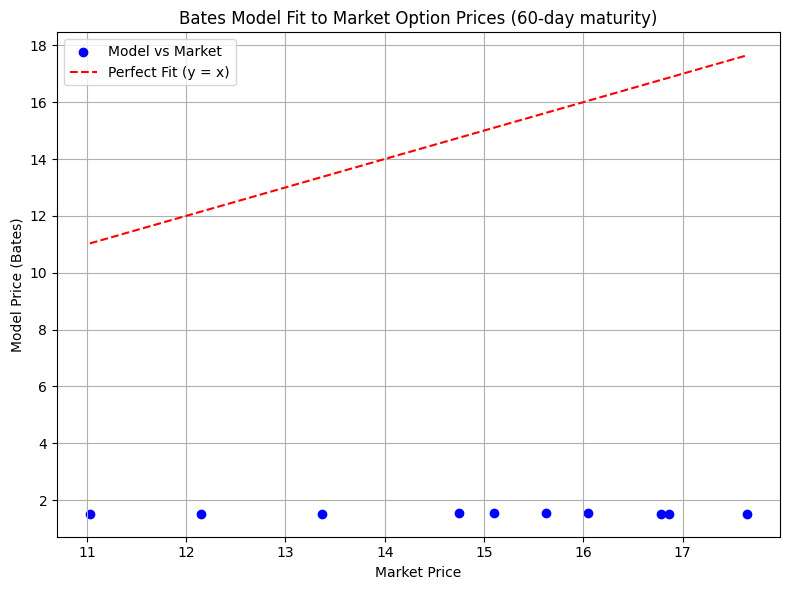

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract calibrated parameters
kappa = calibrated_params_dict["kappa"]
theta = calibrated_params_dict["theta"]
sigma = calibrated_params_dict["sigma"]
v0 = calibrated_params_dict["v0"]
rho = calibrated_params_dict["rho"]
lmbda = calibrated_params_dict["lambda"]
muJ = calibrated_params_dict["muJ"]
sigmaJ = calibrated_params_dict["sigmaJ"]

# Get spot and risk-free rate
S0 = options_60["Spot"].iloc[0]
r = risk_free_rate  # Ensure this is defined

# Prepare lists for plotting
market_prices = []
model_prices = []

# Loop through the option data
for _, row in options_60.iterrows():
    K = row["Strike"]
    T = row["T"]
    market_price = row["Price"]

    model_price = bates_price_fft(K, S0, T, r, v0, theta, kappa, sigma, rho, lmbda, muJ, sigmaJ)

    market_prices.append(market_price)
    model_prices.append(model_price)

# Convert to NumPy arrays for plotting
market_prices = np.array(market_prices)
model_prices = np.array(model_prices)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(market_prices, model_prices, color='blue', label="Model vs Market")
plt.plot([market_prices.min(), market_prices.max()],
         [market_prices.min(), market_prices.max()],
         color='red', linestyle='--', label="Perfect Fit (y = x)")
plt.xlabel("Market Price")
plt.ylabel("Model Price (Bates)")
plt.title("Bates Model Fit to Market Option Prices (60-day maturity)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 2b Calibrate Bates (1996) Model to 60-Day Options Using Carr-Madan (1999) Approach

#### 1. We will begin by loading the data and also filtereing for 60 days maturiry options

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt


In [ ]:

sheet_id = "1YNqTHLMxoGpyehXfpNg7WMbDSdnYQPwR"
sheet_name = "1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

option_data = pd.read_csv(url)

# Adding time-to-maturity in years and risk-free rate
r = 0.015  # 1.5% annualized risk-free rate
option_data["T"] = option_data["Days to maturity"] / 250
option_data["r"] = r  # Set constant risk-free rate
S0 = 232.90  # Current stock price

#Filtering 60 day options
options_60 = option_data[option_data['Days to maturity'] == 60]
options_60.head()

,Days to maturity,Strike,Price,Type,T,r
5,60,227.5,16.78,C,0.24,0.015
6,60,230.0,17.65,C,0.24,0.015
7,60,232.5,16.86,C,0.24,0.015
8,60,235.0,16.05,C,0.24,0.015
9,60,237.5,15.10,C,0.24,0.015


### 2. Define Bates Chacteristic Function for Carr-Madan


It is a combination of two models: Heston and Merton Jump component

In [ ]:

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v)**2 - sigma_v**2 * (-u * 1j - u**2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v**2) * (
        (1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))
    )
    return np.exp(H1 + H2 * v0)



def M76J_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    return np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1)) * T
    )


def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

### 3. Implementing Carr-Madan Pricing Function under FFT

In [ ]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    k = np.log(K / S0)
    alpha = 1.5 if rho < -0.5 else 1.1
    g = 1
    N = g * 8192
    eps = 0.0005
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    if S0 >= 0.95 * K:  # ITM Case
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )
    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )
        v = (vo + 1j * alpha) - 1j
        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    return CallValueM[pos] * S0



def B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    CallValue = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
    return CallValue - S0 + K * np.exp(-r * T)


### 4. Defining the error function for calibration

In [ ]:
# Error function with Tikhonov regularization
def B96_error_function(p, options, S0, p_initial, omega=0.01):
    """Error function for Bates model calibration"""
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p
    # Parameter constraints
    if (kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0 or
        v0 < 0.0 or lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0 or
        2 * kappa_v * theta_v < sigma_v**2):
        return 1e10
    se = []
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        model_value = B96_call_FFT(S0, K, T, r, *p) if option["Type"] == 'C' else B96_put_FFT(S0, K, T, r, *p)
        if np.isnan(model_value) or np.isinf(model_value):
            se.append(1e6)
        else:
            se.append((model_value - option["Price"])**2)
    mse = np.mean(se)
    # Tikhonov regularization
    penalty = omega * np.sqrt(np.sum((p - p_initial) ** 2))
    return mse + penalty

### 5. Running the Calibration
We will  use differential equation to calibrate the bates model to 60-day options

In [ ]:
# Calibration with differential evolution
def B96_calibration_60(options, S0):
    """Calibrate Bates (1996) model to 60-day options"""
    # Initial parameters (from your provided results)
    p_initial = np.array([5.0, 0.04, 0.3, -0.9, 0.03, 0.5, -0.5, 0.5])
    # Parameter bounds
    bounds = [
        (1.0, 10.0),    # kappa_v
        (0.01, 0.1),    # theta_v
        (0.1, 0.5),     # sigma_v
        (-1.0, -0.1),   # rho
        (0.01, 0.1),    # v0
        (0.0, 1.0),     # lamb
        (-0.6, 0.0),    # mu
        (0.0, 0.5)      # delta
    ]
    result = differential_evolution(
        B96_error_function,
        bounds,
        args=(options, S0, p_initial),
        maxiter=50,
        tol=0.01,
        workers=-1,  # Use all CPU cores
        disp=True
    )
    return result.x, result.fun

# Run calibration
calibrated_params_60, mse_60 = B96_calibration_60(options_60, S0)

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 1.669141499393676
differential_evolution step 2: f(x)= 1.5764198307229282
differential_evolution step 3: f(x)= 1.5764198307229282
differential_evolution step 4: f(x)= 1.5764198307229282
differential_evolution step 5: f(x)= 1.5764198307229282
differential_evolution step 6: f(x)= 1.5764198307229282
differential_evolution step 7: f(x)= 1.5764198307229282
differential_evolution step 8: f(x)= 1.5764198307229282
differential_evolution step 9: f(x)= 1.5546368279352591
differential_evolution step 10: f(x)= 1.5546368279352591
differential_evolution step 11: f(x)= 1.5546368279352591
differential_evolution step 12: f(x)= 1.5034207264696648
differential_evolution step 13: f(x)= 1.5034207264696648
differential_evolution step 14: f(x)= 1.4646314131483649
differential_evolution step 15: f(x)= 1.4646314131483649
differential_evolution step 16: f(x)= 1.4646314131483649
differential_evolution step 17: f(x)= 1.4646314131483649
differential_evolution step 18: f(x)= 1.4

In [ ]:
kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = calibrated_params_60

# Dict of the params
calibrated_params_dict = {
    "kappa_v": kappa_v,
    "theta_v": theta_v,
    "sigma_v": sigma_v,
    "rho": rho,
    "v0": v0,
    "lamb": lamb,
    "mu" : mu,
    "delta" : delta }

# Saving the params since it takes time to get them
calibrated_params_dict_df = pd.DataFrame(calibrated_params_dict, index=[0])
calibrated_params_dict_df.to_csv('calibrated_params_dict.csv', index=False)

calibrated_params_dict

{'kappa_v': np.float64(4.991221848567963),
 'theta_v': np.float64(0.1),
 'sigma_v': np.float64(0.1),
 'rho': np.float64(-0.1),
 'v0': np.float64(0.017451766310659058),
 'lamb': np.float64(1.0),
 'mu': np.float64(0.0),
 'delta': np.float64(0.5)}

### 6. Compairing with results from  2a

### 7. Plotting Market vs Model Prices

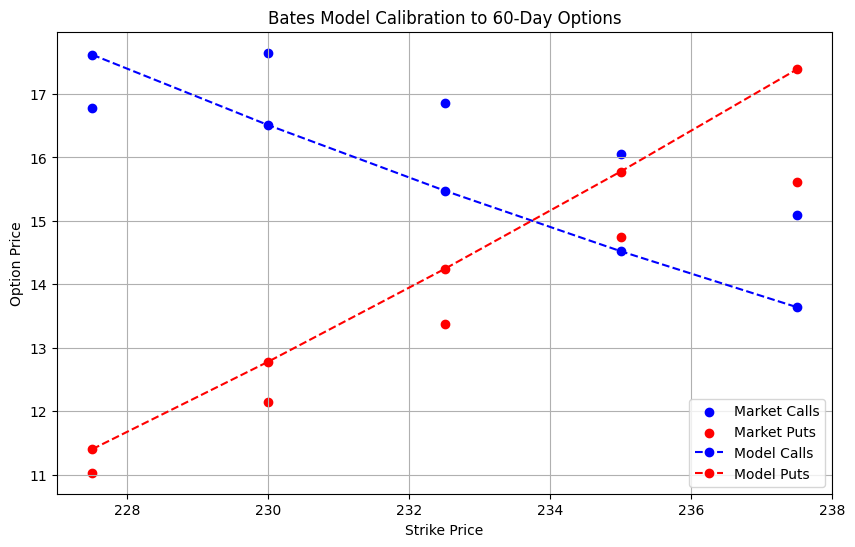

In [ ]:
def plot_calibration_results_60(calibrated_params, options, S0):
    """
    Calculate model prices for 60-day options using calibrated parameters
    """
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = calibrated_params
    options["Model"] = 0.0
    for _, option in options.iterrows():
        K = option["Strike"]
        T = option["T"]
        r = option["r"]
        if option["Type"] == 'C':
            model_price = B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        else:
            model_price = B96_put_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
        options.loc[_, "Model"] = model_price

    # Plotting the results
    plt.figure(figsize=(10, 6))
    calls = options[options["Type"] == 'C']
    puts = options[options["Type"] == 'P']
    plt.scatter(calls["Strike"], calls["Price"], c='b', label="Market Calls")
    plt.scatter(puts["Strike"], puts["Price"], c='r', label="Market Puts")
    plt.plot(calls["Strike"], options[options["Type"] == 'C']["Model"], 'bo--', label="Model Calls")
    plt.plot(puts["Strike"], options[options["Type"] == 'P']["Model"], 'ro--', label="Model Puts")
    plt.grid()
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title("Bates Model Calibration to 60-Day Options")
    plt.legend()
    plt.show()

options_60_copy = options_60.copy()
plot_calibration_results_60(calibrated_params_60, options_60_copy, S0)

### 8. Analyzing Residuals

In [ ]:
options_60_copy["Residual"] = options_60_copy['Model'] - options_60_copy['Price']
MSE_60 = np.mean(options_60_copy['Residual'] ** 2)
RMSE_60 = np.sqrt(MSE_60)
print(f"MSE for 60-day options: {MSE_60:.4f}\nRMSE for 60-day options: {RMSE_60:.4f}")


MSE for 60-day options: 1.3860
RMSE for 60-day options: 1.1773


In [ ]:
options_60_copy

,Days to maturity,Strike,Price,Type,T,r,Model,Residual
5,60,227.5,16.78,C,0.24,0.015,17.618659,0.838659
6,60,230.0,17.65,C,0.24,0.015,16.508146,-1.141854
7,60,232.5,16.86,C,0.24,0.015,15.476661,-1.383339
8,60,235.0,16.05,C,0.24,0.015,14.521673,-1.528327
9,60,237.5,15.10,C,0.24,0.015,13.640106,-1.459894
20,60,227.5,11.03,P,0.24,0.015,11.401131,0.371131
21,60,230.0,12.15,P,0.24,0.015,12.781635,0.631635
22,60,232.5,13.37,P,0.24,0.015,14.241166,0.871166
23,60,235.0,14.75,P,0.24,0.015,15.777194,1.027194
24,60,237.5,15.62,P,0.24,0.015,17.386643,1.766643


### 9. How Parameter for Lewis and Carr-Madan Compare ?

# Step 3

### 3a Calibrate a CIR (1985) Model to Euribor Rates and Simulate Future Rates
We will model and simulate future interest rates using Cox-Ingersoll-Ross (CIR) model.

### Model Overview
$$
dr_t = \kappa_r(\theta_r - r_t)dt + \sigma_r\sqrt{r_t}dW_t
$$

where:
- $r_t$ - Short term interest rate at time t
- $\kappa_r$ - Mean-reversion speed
- $\theta_r$ - Long-term mean of interest rates
- $\sigma_r$ - Volatility of interest rates
- $dW_t$ - Brownian motion

### 1. Loading and Interpolating Euribor Term Structure

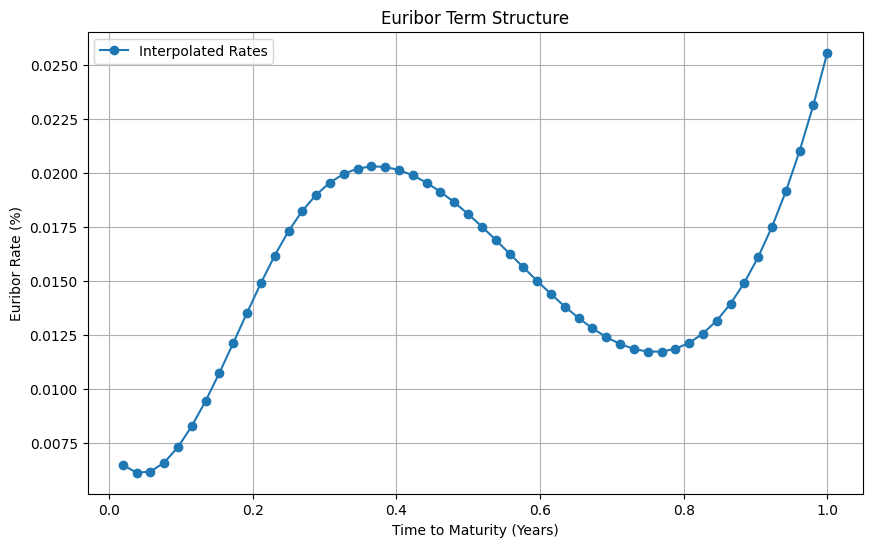

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import brute, fmin
import matplotlib.pyplot as plt

# Load the data
terms = np.array([1/52, 1/12, 1/4, 1/2, 1])
rates = np.array([0.00648, 0.00679, 0.0173, 0.01809, 0.02556])

# Create a cubic spline interpolation
spline = CubicSpline(terms, rates)

# Generate weekly points for interpolation
weekly_terms = np.arange(1, 53) / 52
weekly_rates = spline(weekly_terms)

# Create a DataFrame for the original rates
bond_rates = pd.DataFrame({
    'Term (Years)': terms,
    'Rate': rates
})

# Create a DataFrame for the interpolated rates
interpolated_rates = pd.DataFrame({
    'Term (Years)': weekly_terms,
    'Interpolated Rate': weekly_rates
})

# Plotting the interpolated rates
plt.figure(figsize=(10, 6))
plt.plot(interpolated_rates['Term (Years)'], interpolated_rates['Interpolated Rate'], marker='o', label='Interpolated Rates')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Euribor Rate (%)')
plt.title('Euribor Term Structure')
plt.grid(True)
plt.legend()
plt.show()


### Step 2 Calibrating the CIR Model for the Term Structure

For this we will use CIR model  which  implies a bond price formula:
$$
P(t, T) = A(t, T)e^{-B(t, T)r_t}
$$
- First we will define an error function that compares market bond prices and CIR model bond prices then use `scipy.optimize ` to minimize the RMSE between market and model prices

In [ ]:
def CIR_bond_price(r0, T, kappa_r, theta_r, sigma_r):
    """
    CIR bond price formula
    """
    h = np.sqrt(kappa_r**2 + 2 * sigma_r**2)
    B = 2 * (np.exp(h * T) - 1) / (2 * h + (h + kappa_r) * (np.exp(h * T) - 1))
    A = (2 * h * np.exp((h + kappa_r) * T / 2) / (2 * h + (h + kappa_r) * (np.exp(h * T) - 1))) ** (2 * kappa_r * theta_r / sigma_r**2)
    A = np.exp((kappa_r * theta_r - 0.5 * sigma_r**2) * T)
    return A * np.exp(-B * r0)

def CIR_error_function(p0, bond_data, r0):
    """
    Error function for CIR model calibration
    """
    kappa_r, theta_r, sigma_r = p0

    # Parameter constraints
    if kappa_r < 0.0 or theta_r < 0.0 or sigma_r < 0.0:
        return 5000.0

    # Compute MSE
    se = []
    for _, bond in bond_data.iterrows():
        T = bond["Term (Years)"]
        market_price = bond["Bond Price"]
        model_price = CIR_bond_price(r0, T, kappa_r, theta_r, sigma_r)
        se.append((model_price - market_price)**2)

    MSE = sum(se) / len(se)
    return MSE

def CIR_calibration(bond_data, r0):
    """
    Calibrate CIR model to bond data
    """
    # Brute-force scan for initial guesses
    p0 = brute(
        lambda p: CIR_error_function(p, bond_data, r0),
        (
            (0.1, 5.0, 0.5),  # kappa_r
            (0.01, 0.1, 0.01),  # theta_r
            (0.01, 0.5, 0.05)   # sigma_r
        ),
        finish=None
    )

    # Refining with fmin
    opt = fmin(lambda p: CIR_error_function(p, bond_data, r0),
               p0,
               xtol=0.0001,
               ftol=0.0001,
               maxiter=500,
               maxfun=1000)
    return opt

# Running the calibration
# adding bond price
bond_prices = CIR_bond_price(0.00648, bond_rates['Term (Years)'], 0.1, 0.01, 0.05)
bond_rates['Bond Price'] = bond_prices
calibrated_params_cir = CIR_calibration(bond_rates, r0=0.00648)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 41


### Step 3: Simulating Future 12 month Euribor Rates

We will use the calibrated CIR parameter from  above step  to  simulate future rates

In [ ]:
def simulate_CIR(r0, T, N, kappa_r, theta_r, sigma_r, paths=100000):
    """
    Simulate future interest rates using the CIR model
    """
    dt = T / N
    rates = np.zeros((paths, N + 1))
    rates[:, 0] = r0

    for i in range(1, N + 1):
        # Ensure rates do not become negative before taking the square root
        rates[:, i-1] = np.maximum(rates[:, i-1], 0)
        dr = kappa_r * (theta_r - rates[:, i - 1]) * dt + sigma_r * np.sqrt(rates[:, i - 1]) * np.random.normal(size=paths) * np.sqrt(dt)
        rates[:, i] = rates[:, i - 1] + dr
        # Ensure rates do not become negative after adding the increment
        rates[:, i] = np.maximum(rates[:, i], 0)

    return rates

# Simulating 12 months of interest rates
r0 = interpolated_rates[interpolated_rates['Term (Years)'] == 1.0]['Interpolated Rate'].values[0]
T = 1 # 1 year
N = 250 # Daily steps
paths = 100000 # Number of paths
kappa_r, theta_r, sigma_r = calibrated_params_cir

future_rates = simulate_CIR(r0, T, N, kappa_r, theta_r, sigma_r, paths)

# Computing Confidence Intervals
confidence_intervals = np.percentile(future_rates, [2.5, 97.5], axis=0)
excepted_rate = np.mean(future_rates, axis=0)


print(f"95% confidence intervals for 12 months of interest rates in 1 year: [{confidence_intervals[0][-1]: .4f}, {confidence_intervals[1][-1]: .4f}]")
print(f"Expected interest rate in 1 year: {excepted_rate[-1]: .4f}")

95% confidence intervals for 12 months of interest rates in 1 year: [ 0.0036,  0.0706]
Expected interest rate in 1 year:  0.0289
